# Estudio de la evolución de la pandemia por el modelo de red neuronal recurrente para la isla de Tenerife

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, indices, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    color_isla = 'blue'
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)
    
    return modelo
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_Tenerife = datos[datos['isla'] == 'TENERIFE']

datos_Tenerife = datos_Tenerife.set_index('fecha') # Asignamos la fecha como índice

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'Tenerife'         # Isla a la que se está realziando el estudio
fechas = datos_Tenerife.tail(dias_prediccion).index # Fechas de los días a predecir


variables_covid = [objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = [objetivo, 'tmin', 'tmed', 'presMax']                            # Atributos para el análisis de las variables atmosféricas
variables = [objetivo,'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables


In [5]:

# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_Tenerife_uni = datos_Tenerife[objetivo]
datos_Tenerife_uni_arr = np.array(datos_Tenerife_uni).reshape(-1, 1)

datos_Tenerife_mult_covid = datos_Tenerife[variables_covid]
datos_Tenerife_mult_atm = datos_Tenerife[variables_atm]
datos_Tenerife_mult_total = datos_Tenerife[variables]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_uni_scaled = scaler.fit_transform(datos_Tenerife_uni_arr)

In [7]:
n_train = len(datos_Tenerife_uni_scaled) - dias_prediccion


train = datos_Tenerife_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_uni_scaled[n_train - dias_prediccion:len(datos_Tenerife_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
14/14 [==============================] - 4s 41ms/step - loss: 0.0457 - val_loss: 0.0276
Epoch 2/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0408 - val_loss: 0.0251
Epoch 3/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0373 - val_loss: 0.0226
Epoch 4/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0334 - val_loss: 0.0220
Epoch 5/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0299 - val_loss: 0.0202
Epoch 6/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0265 - val_loss: 0.0195
Epoch 7/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0237 - val_loss: 0.0205
Epoch 8/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0206 - val_loss: 0.0158
Epoch 9/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0203 - val_loss: 0.0161
Epoch 10/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0205 - val_loss: 0.0168
Epoch 11/

In [10]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 499ms/step


In [11]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 777.46625
2022-03-20: número de casos reales 193, número de casos predichos 745.2719
2022-03-21: número de casos reales 636, número de casos predichos 709.4109
2022-03-22: número de casos reales 760, número de casos predichos 658.57214
2022-03-23: número de casos reales 716, número de casos predichos 680.9402
2022-03-24: número de casos reales 607, número de casos predichos 720.28845
2022-03-25: número de casos reales 636, número de casos predichos 651.34283
2022-03-26: número de casos reales 266, número de casos predichos 580.9994
2022-03-27: número de casos reales 163, número de casos predichos 538.834
2022-03-28: número de casos reales 319, número de casos predichos 527.1115


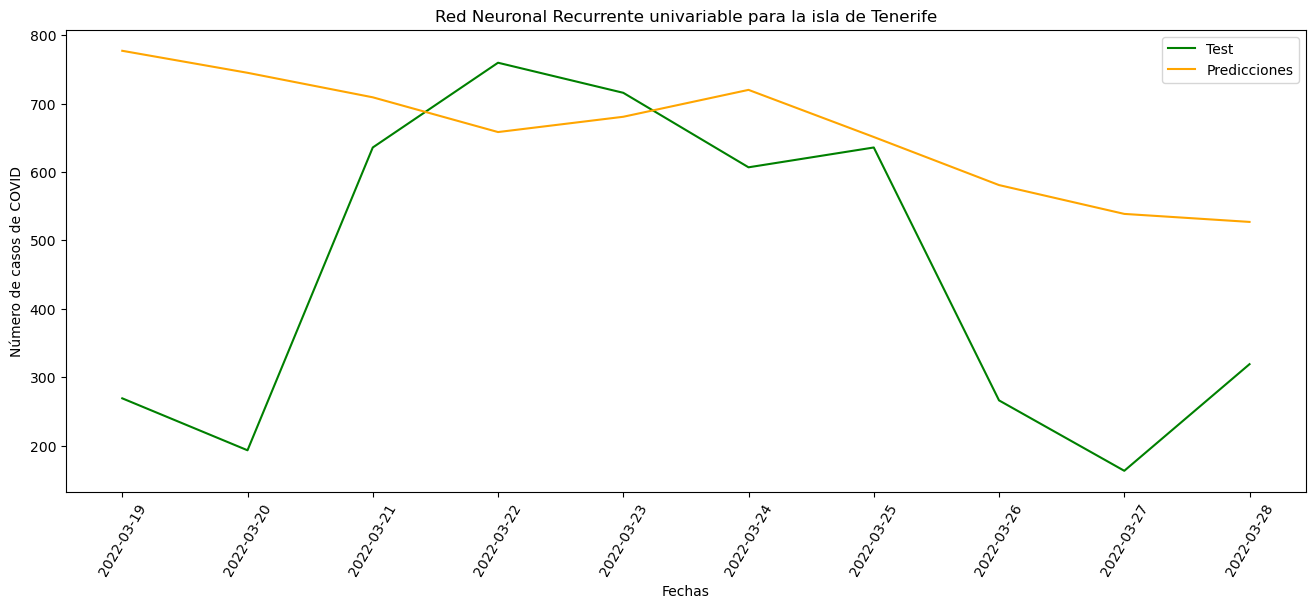

In [12]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

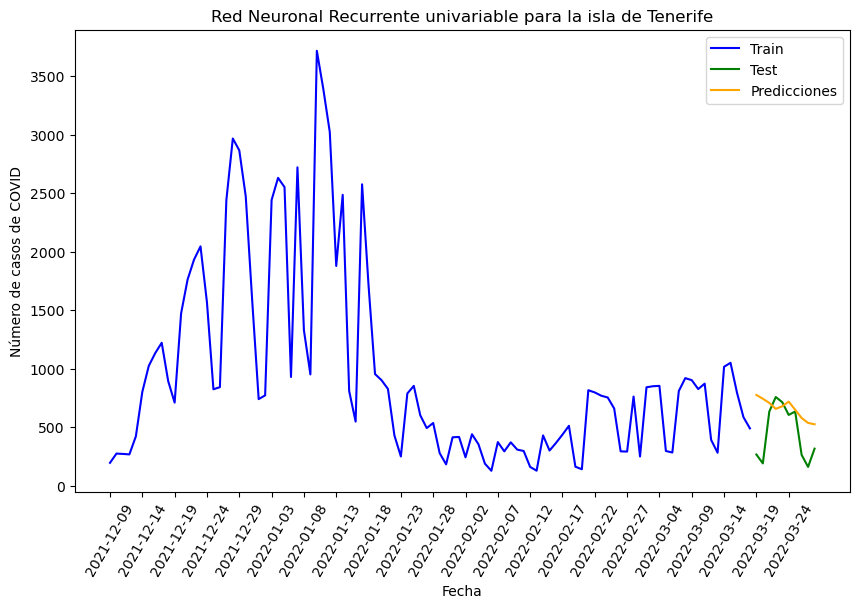

In [13]:
datos_train = datos_Tenerife_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit)

In [14]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 87730.40248566568
Error absoluto medio (MAE) del modelo: 229.8212890625
Raíz del error cuadrático medio (RMSE) del modelo: 296.19318440110277


# Red Neuronal Recurrente multivariable con variables de pandemia

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled = scaler.fit_transform(datos_Tenerife_mult_covid)


# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_covid[objetivo]).reshape(-1, 1))

In [16]:
n_train = len(datos_Tenerife_mult_covid_scaled) - dias_prediccion


train = datos_Tenerife_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_covid_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_covid_scaled), :]

In [17]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [18]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
14/14 [==============================] - 4s 40ms/step - loss: 0.0423 - val_loss: 0.0248
Epoch 2/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0372 - val_loss: 0.0217
Epoch 3/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0329 - val_loss: 0.0201
Epoch 4/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0280 - val_loss: 0.0188
Epoch 5/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0254 - val_loss: 0.0176
Epoch 6/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0233 - val_loss: 0.0187
Epoch 7/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0226 - val_loss: 0.0157
Epoch 8/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0204 - val_loss: 0.0159
Epoch 9/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0186 - val_loss: 0.0163
Epoch 10/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0194 - val_loss: 0.0132
Epoch 11/

In [19]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 320ms/step


In [20]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 742.1344
2022-03-20: número de casos reales 193, número de casos predichos 705.77386
2022-03-21: número de casos reales 636, número de casos predichos 675.97424
2022-03-22: número de casos reales 760, número de casos predichos 635.01605
2022-03-23: número de casos reales 716, número de casos predichos 664.3865
2022-03-24: número de casos reales 607, número de casos predichos 705.87054
2022-03-25: número de casos reales 636, número de casos predichos 657.62585
2022-03-26: número de casos reales 266, número de casos predichos 615.92114
2022-03-27: número de casos reales 163, número de casos predichos 585.65765
2022-03-28: número de casos reales 319, número de casos predichos 575.1242


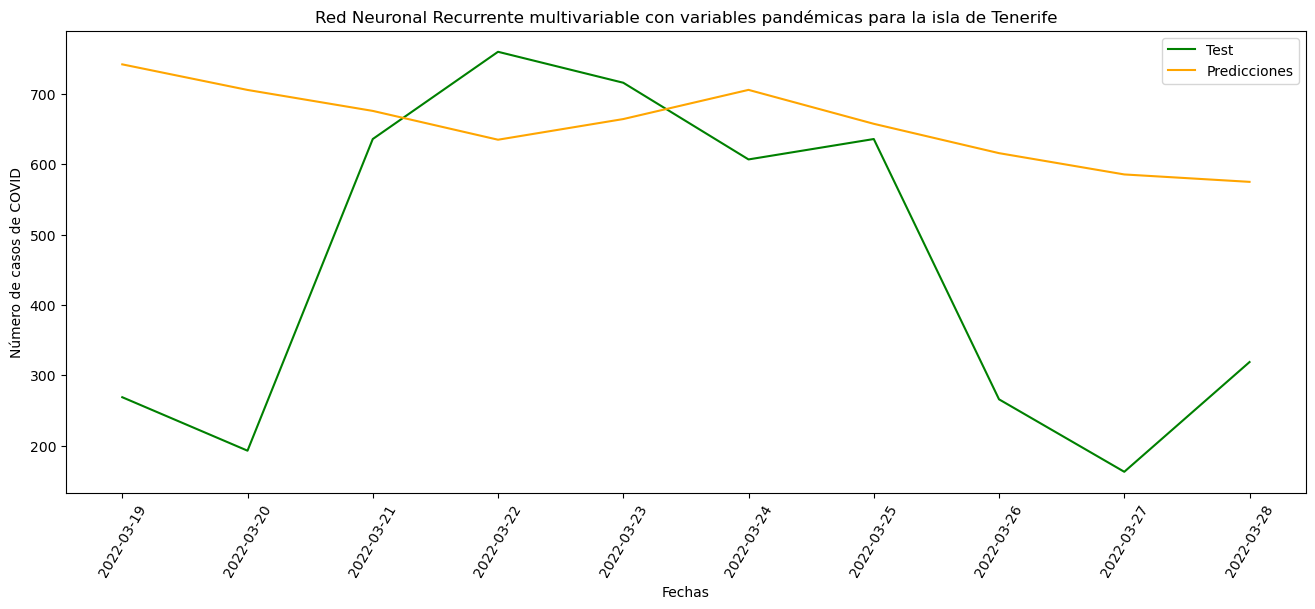

In [21]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

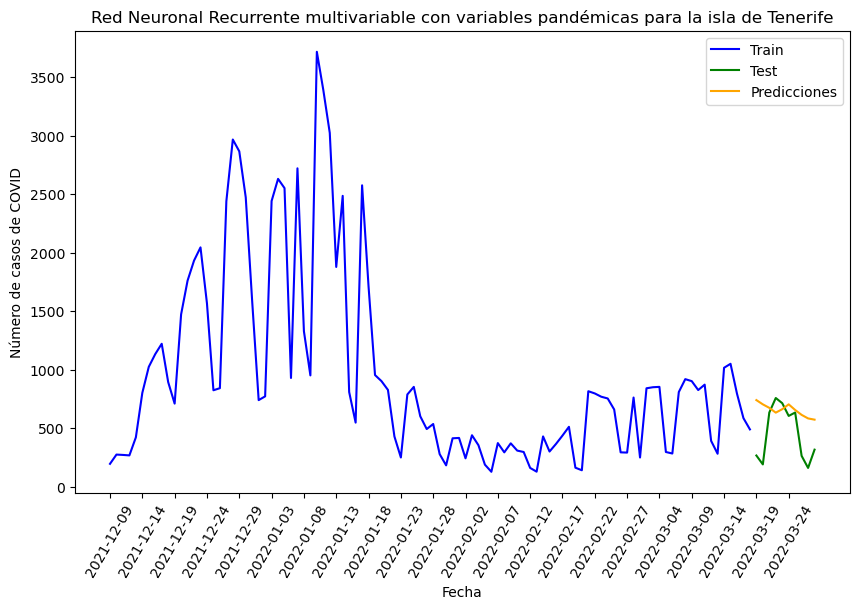

In [22]:
datos_train = datos_Tenerife_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [23]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 88360.30492540337
Error absoluto medio (MAE) del modelo: 235.16793823242188
Raíz del error cuadrático medio (RMSE) del modelo: 297.2546129589974


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled = scaler.fit_transform(datos_Tenerife_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_atm[objetivo]).reshape(-1, 1))

In [25]:
n_train = len(datos_Tenerife_mult_atm_scaled) - dias_prediccion


train = datos_Tenerife_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_atm_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_atm_scaled), :]

In [26]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [27]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
14/14 [==============================] - 3s 41ms/step - loss: 0.0436 - val_loss: 0.0265
Epoch 2/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0405 - val_loss: 0.0231
Epoch 3/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0371 - val_loss: 0.0218
Epoch 4/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0343 - val_loss: 0.0203
Epoch 5/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0322 - val_loss: 0.0184
Epoch 6/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0293 - val_loss: 0.0175
Epoch 7/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0250 - val_loss: 0.0162
Epoch 8/50
14/14 [==============================] - 0s 10ms/step - loss: 0.0228 - val_loss: 0.0145
Epoch 9/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0212 - val_loss: 0.0153
Epoch 10/50
14/14 [==============================] - 0s 11ms/step - loss: 0.0202 - val_loss: 0.0154
Epoch 11/

In [28]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 321ms/step


In [29]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 748.3215
2022-03-20: número de casos reales 193, número de casos predichos 705.0352
2022-03-21: número de casos reales 636, número de casos predichos 657.931
2022-03-22: número de casos reales 760, número de casos predichos 611.1508
2022-03-23: número de casos reales 716, número de casos predichos 634.3641
2022-03-24: número de casos reales 607, número de casos predichos 669.13293
2022-03-25: número de casos reales 636, número de casos predichos 602.6104
2022-03-26: número de casos reales 266, número de casos predichos 531.5476
2022-03-27: número de casos reales 163, número de casos predichos 487.84842
2022-03-28: número de casos reales 319, número de casos predichos 470.3126


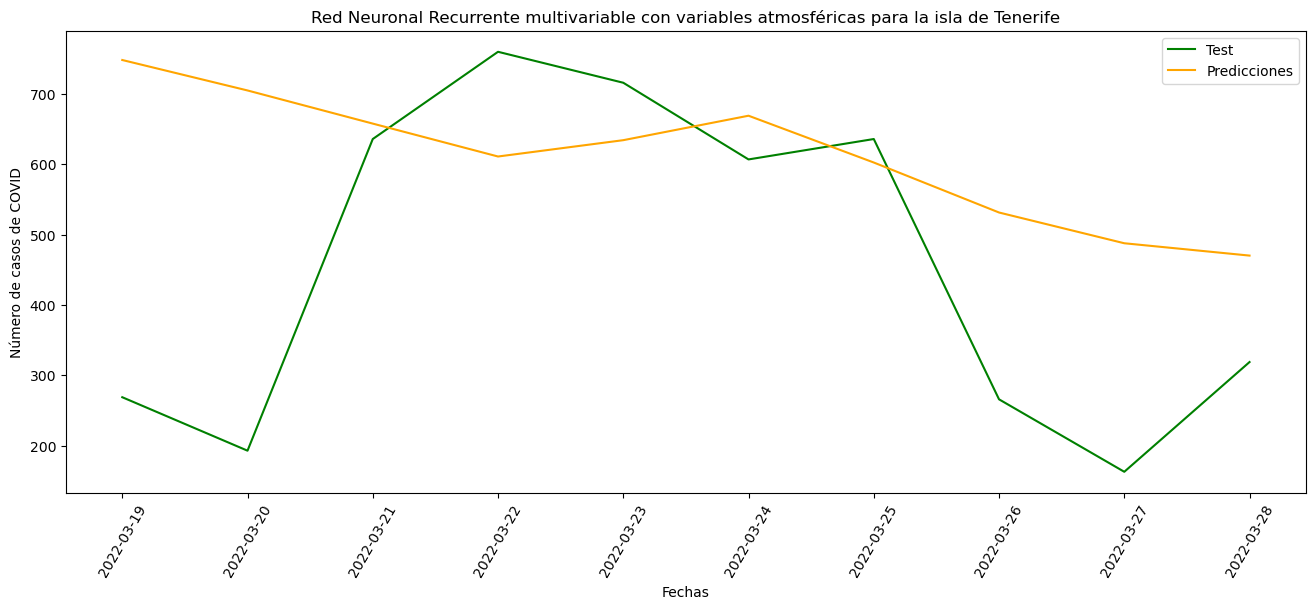

In [30]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

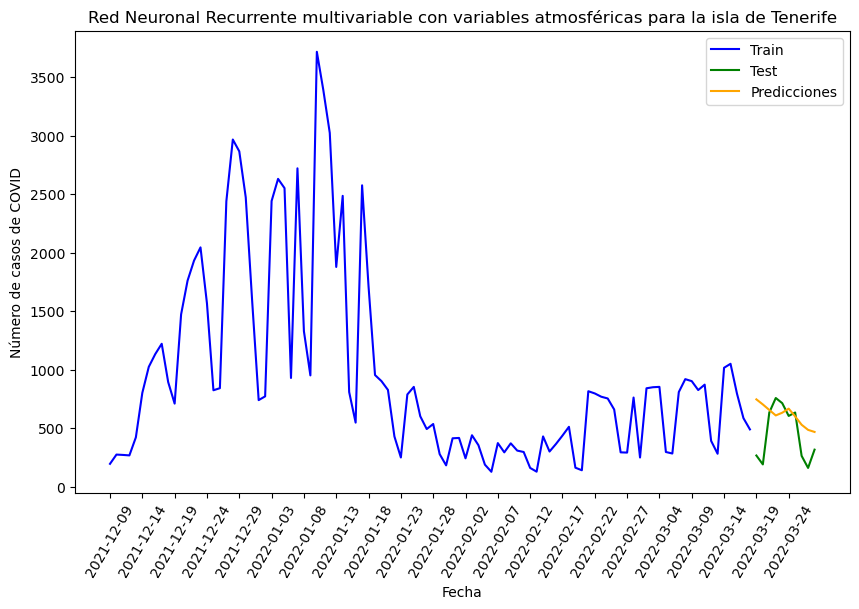

In [31]:
datos_train = datos_Tenerife_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [32]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 72514.35045542549
Error absoluto medio (MAE) del modelo: 208.10039672851562
Raíz del error cuadrático medio (RMSE) del modelo: 269.2848871649233


# Red Neuronal Recurrente multivariable con todas las variables

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled = scaler.fit_transform(datos_Tenerife_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_Tenerife_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_Tenerife_mult_total[objetivo]).reshape(-1, 1))

In [34]:
n_train = len(datos_Tenerife_mult_total_scaled) - dias_prediccion


train = datos_Tenerife_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_Tenerife_mult_total_scaled[n_train - dias_prediccion:len(datos_Tenerife_mult_total_scaled), :]

In [35]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [36]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
14/14 [==============================] - 5s 63ms/step - loss: 0.0372 - val_loss: 0.0225
Epoch 2/50
14/14 [==============================] - 0s 14ms/step - loss: 0.0308 - val_loss: 0.0192
Epoch 3/50
14/14 [==============================] - 0s 14ms/step - loss: 0.0271 - val_loss: 0.0179
Epoch 4/50
14/14 [==============================] - 0s 15ms/step - loss: 0.0251 - val_loss: 0.0171
Epoch 5/50
14/14 [==============================] - 0s 15ms/step - loss: 0.0218 - val_loss: 0.0215
Epoch 6/50
14/14 [==============================] - 0s 14ms/step - loss: 0.0215 - val_loss: 0.0235
Epoch 7/50
14/14 [==============================] - 0s 14ms/step - loss: 0.0199 - val_loss: 0.0169
Epoch 8/50
14/14 [==============================] - 0s 14ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 9/50
14/14 [==============================] - 0s 14ms/step - loss: 0.0175 - val_loss: 0.0121
Epoch 10/50
14/14 [==============================] - 0s 16ms/step - loss: 0.0156 - val_loss: 0.0180
Epoch 11/

In [37]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 313ms/step


In [38]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 269, número de casos predichos 832.357
2022-03-20: número de casos reales 193, número de casos predichos 801.03217
2022-03-21: número de casos reales 636, número de casos predichos 768.3669
2022-03-22: número de casos reales 760, número de casos predichos 721.97516
2022-03-23: número de casos reales 716, número de casos predichos 756.2075
2022-03-24: número de casos reales 607, número de casos predichos 773.6897
2022-03-25: número de casos reales 636, número de casos predichos 725.24506
2022-03-26: número de casos reales 266, número de casos predichos 676.1184
2022-03-27: número de casos reales 163, número de casos predichos 635.4147
2022-03-28: número de casos reales 319, número de casos predichos 627.64594


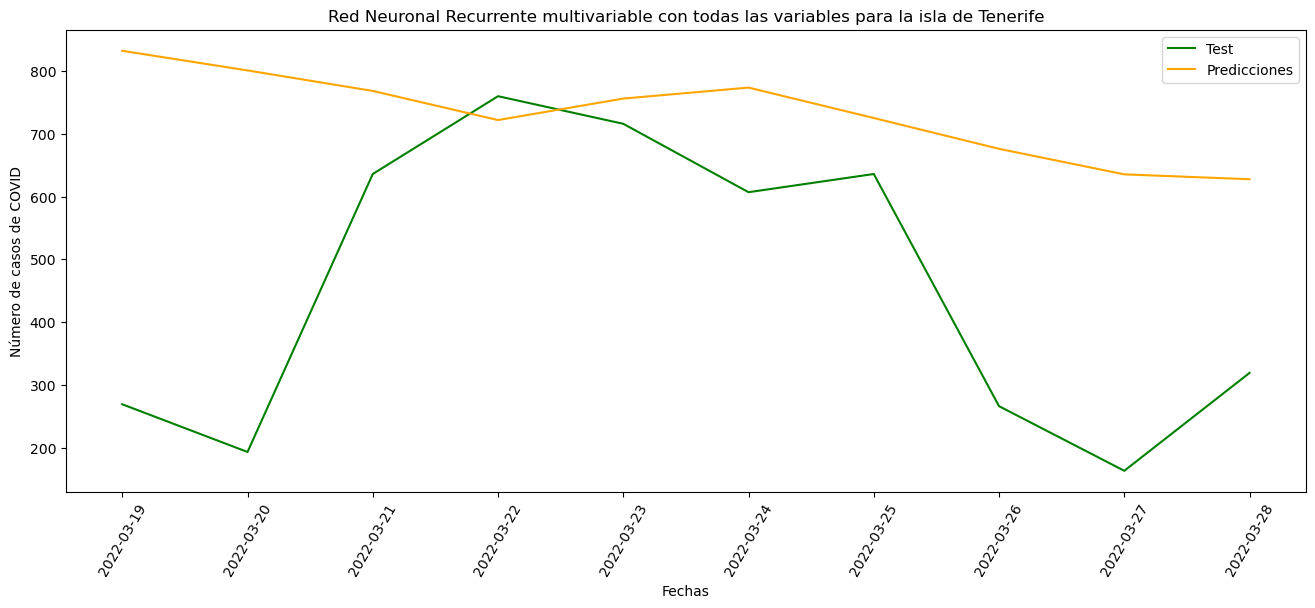

In [39]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

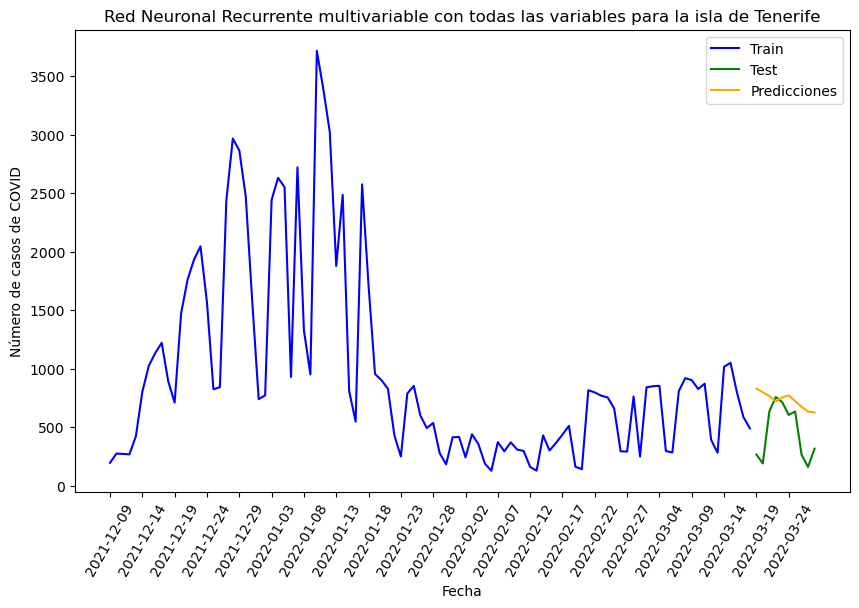

In [40]:
datos_train = datos_Tenerife_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [41]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 123004.29227556661
Error absoluto medio (MAE) del modelo: 282.91021728515625
Raíz del error cuadrático medio (RMSE) del modelo: 350.7196776281117
